In [1]:
import tensorflow as tf
from collections import Counter
import re
import pandas as pd
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt


In [2]:
"去除标点"
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub("",line)
    
    return line

"获取label"
def get_cat():
    cat = set()
    with open("cnews\cnews.train.txt",encoding='utf-8') as f:
        for i in f.readlines():
            text = i.split('\t')[0]
            cat.add(text)
    return list(cat)



"转换为字，并以csv格式输出"
def text_cut(data_path):

    with open(data_path+"dict_word",encoding='utf-8') as f:
        dict_word = eval(f.readline())
    
    cat = get_cat()
    
    text_cut_one(data_path+"cnews.train.txt",output_path=os.getcwd()+"\\cnews\\train.csv",dict_word=dict_word,cat=cat)
    text_cut_one(data_path+"cnews.test.txt",output_path=os.getcwd()+"\\cnews\\test.csv",dict_word=dict_word,cat=cat)
    text_cut_one(data_path+"cnews.val.txt",output_path=os.getcwd()+"\\cnews\\val.csv",dict_word=dict_word,cat=cat)
    
                
def text_cut_one(data_path,output_path,dict_word,cat):
    
    df = pd.DataFrame()
    
    labels = []
    texts = []
    
    with open(data_path,encoding='utf-8') as f:
        for i in f.readlines():
            label = i.split('\t')[0]
            labels.append(cat.index(label))
            text = i.split('\t')[1]
            text = remove_punctuation(text)
            l = []
            for j in text:
                l.append(j)
                
            texts.append(",".join(l))

    df['text'] = texts
    df['label'] = labels
    
    df.to_csv(output_path)
    print("完成！！")

In [4]:
text_cut("cnews/")

完成！！
完成！！
完成！！


In [5]:
tf.test.is_built_with_cuda()

False

In [8]:
vocab_size = 5000
embedding_dim = 128
max_length = 128
trunc_type = 'post' #从后截取
padding_type = 'post' #从后填充
unk_tok = '<unk>'

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,dropout=0.5)),
    tf.keras.layers.LSTM(embedding_dim,dropout=0.5),
    tf.keras.layers.Dense(embedding_dim,activation='relu'),#kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(11,activation='softmax')#,kernel_regularizer=tf.keras.regularizers.l2())
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1419      
Total params: 789,515
Trainable params: 789,515
Non-trainable params: 0
_________________________________________________________________


In [9]:
train = pd.read_csv("cnews\\train.csv")
val = pd.read_csv("cnews\\val.csv")
test = pd.read_csv("cnews\\test.csv")

In [10]:
tokenizer = Tokenizer(num_words=vocab_size,split=',',oov_token=unk_tok)
tokenizer.fit_on_texts(train.text.values)

In [11]:
len(tokenizer.index_word)

5707

In [12]:
x_train_squences = tokenizer.texts_to_sequences(train.text.values)
x_train_pad = pad_sequences(x_train_squences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

x_val_squences = tokenizer.texts_to_sequences(val.text.values)
x_val_pad = pad_sequences(x_val_squences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

In [13]:
y_train_seq = np.array(train.label.values)
y_val_seq = np.array(val.label.values)

In [14]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [15]:
history = model.fit(x_train_pad,y_train_seq,batch_size = 64,validation_data =(x_val_pad,y_val_seq),epochs=15)

Train on 50000 samples, validate on 5000 samples
Epoch 1/15
50000/50000 [==============================] - 173s 3ms/sample - loss: 1.5161 - accuracy: 0.4297 - val_loss: 1.4148 - val_accuracy: 0.4946
Epoch 2/15
50000/50000 [==============================] - 176s 4ms/sample - loss: 0.8593 - accuracy: 0.7128 - val_loss: 0.7181 - val_accuracy: 0.7762
Epoch 3/15
50000/50000 [==============================] - 181s 4ms/sample - loss: 0.3752 - accuracy: 0.8868 - val_loss: 0.5326 - val_accuracy: 0.8442
Epoch 4/15
50000/50000 [==============================] - 189s 4ms/sample - loss: 0.2448 - accuracy: 0.9275 - val_loss: 0.4346 - val_accuracy: 0.8690
Epoch 5/15
50000/50000 [==============================] - 188s 4ms/sample - loss: 0.1929 - accuracy: 0.9436 - val_loss: 0.3812 - val_accuracy: 0.8866
Epoch 6/15
50000/50000 [==============================] - 194s 4ms/sample - loss: 0.1556 - accuracy: 0.9536 - val_loss: 0.3575 - val_accuracy: 0.8926
Epoch 7/15
50000/50000 [===========================

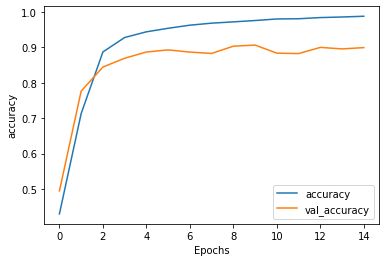

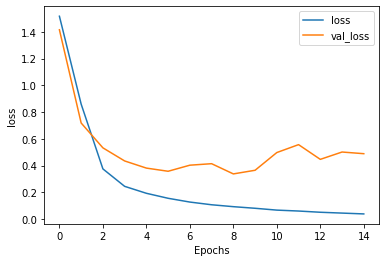

In [16]:

def plot_graphs(history, string):    
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")